# Notebook #03: Investigation on item provider fairness

Considering the impact of recommendations on **item providers** is one of the duties of multi-sided recommender systems. Item providers are key stakeholders in online platforms, and their earnings and plans are influenced by the exposure their items receive in recommended lists. Prior work showed that certain minority groups of providers, characterized by a common sensitive attribute (e.g., gender or race), are being disproportionately affected by indirect and unintentional discrimination. This notebook will consider the **directors of movies in Movielens 1M** as **the item providers** and investigates how unfairness on gender-based demoraphic groups of providers affects providers' group visibility and exposure with respect to their representation in the item catalog.

Our study encodes the idea of a **group-level proportionality between the contribution in the catalog and the relevance, the visibility, and the exposure**, following a distributive norm based on equity. Operationalizing this notion during the user-item relevance optimization stage may be envisioned as a proactive way of addressing provider’s fairness along the recommendation pipeline, given that relevance scores are the input for the ranking stage. Being optimized for their ability to rank, the estimated relevance scores directly influence the chance of an item being ranked high (i.e., the higher the relevance is, the more likely the item appears at the top). If these relevances are biased against the minority group, the recommender system is unfairly giving minority items less chance of being ranked high. The disparate impact we address consists in items of a small minority group of providers systematically receiving unfairly low relevance, and by extension an exposure not proportional to their contribution in the catalog. Our goal in this notebook is thus to investigate whether, during the recommendation learning stage, taking actions for increasing the relevance of items from the minority group positively impacts on providers’ group fairness.

Under this scenario, to reduce disparities in relevance and exposure, we propose a **pre-processing strategy** that up-samples interactions where the minority group is predominant (e.g., an item where the minority is represented with two providers is better than item with only one provider of that group; moreover, the lower is the representation of the majority in that item, the more we can help the minority, by favoring an upsampling of these latter items). In addition, an **in-processing component** aims to control that the relevance to the items of the minority group is proportional to its contribution in the catalog. 

Specifically, in this notebook, we will:
- load the Movielens 1M dataset; 
- identify the representation of each gender-based group of providers for each item and across items;
- investigate the visibility and exposure of the minority group of providers given by some recommender models; 
- work with a pre-processing treatment against provider unfairness, by upsampling interactions involving the minority;
- investigate the impact of our pre-processing treatment on the visibility and exposure of providers;
- extend the unfairness treatment with an in-processing approach which encodes a group proportionality for relevance scores;
- investigate again the impact of our pre-processing treatment on the visibility and exposure of providers;
- identify the limitations and future challenges derived from the presented work. 

**While gender is by no means a binary construct, to the best of our knowledge no dataset with non-binary genders exists. What we are considering is a binary feature, as the current publicly available platforms offer.**

- Boratto, Ludovico, Gianni Fenu, and Mirko Marras. "Interplay between Upsampling and Regularization for Provider Fairness in Recommender Systems." arXiv preprint arXiv:2006.04279 (2020).

## Setup the working environment for this tutorial

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/icdm2020/notebooks

In [1]:
import sys 
import os

sys.path.append(os.path.join('..'))

In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from helpers.train_test_splitter import *
from helpers.instances_upsampler import *
from models.pointwise import PointWise
from models.pairwise import PairWise
from models.mostpop import MostPop
from models.random import Random
from helpers.utils import *

In [5]:
data_path = '../data/'

## Step 1: Computing the representation of gender groups of providers in the dataset 

The first step will require us to load the Movielens 1M dataset and inspect to what extent the different groups of providers are represented in the catalog.   

##### Input of this step: CSV file including user preferences

In [6]:
dataset = 'ml1m'          
method = 'utime_pfair'
user_field = 'user_id'
item_field = 'item_id'
rating_field = 'rating'
time_field = 'timestamp'
type_field = 'type_id'

In [7]:
data = pd.read_csv('../data/datasets/' + dataset + '.csv', encoding='utf8')

In [8]:
data.sample(n=10, random_state=1)

,user_id,item_id,rating,timestamp,type,type_id
630120,3752,319,4.0,2000-08-13 01:03:20,Thriller,15
229398,2411,39,4.0,2000-11-19 00:38:54,Romance,13
758377,2172,2915,3.0,2002-03-02 22:18:54,Comedy,4
159240,2366,349,3.0,2000-11-16 03:11:21,Action,0
254252,1017,377,4.0,2000-11-23 21:15:04,Thriller,15
27168,3391,527,5.0,2000-08-29 19:18:26,Drama,7
196538,2376,1580,4.0,2002-06-19 12:58:43,Comedy,4
37123,4635,783,3.0,2000-07-19 21:31:53,Musical,11
982048,868,1346,4.0,2000-11-26 23:13:31,Horror,10
994502,1880,2275,4.0,2000-11-20 05:37:43,Adventure,1


Now, in order to associate to each interaction the extent to which it involves each group of providers, we need to append the gender information to the interactions included in the original dataset. We will leverage a csv that, for each item, gives the percentage of directors belonging to the two genders. Please note that more than one director can be associated to a movie. 

In [9]:
gender_item_association = pd.read_csv('../data/datasets/' + dataset + '-dir-gender' + '.csv', encoding='utf8')

In [10]:
gender_item_association.head()

,item_id,gender_1,gender_2
0,661,0.0,1.0
1,914,0.0,1.0
2,3408,0.0,1.0
3,2355,0.0,1.0
4,1197,0.0,1.0


In [11]:
len(gender_item_association[gender_item_association['gender_1'] > 0]) / len(gender_item_association)

0.05450620615218565

In [12]:
len(gender_item_association[gender_item_association['gender_1'] == 0]) / len(gender_item_association)

0.8375607123583378

We can observe that the first gender group represents a minority provider group in this dataset, with a representation of 5% in the catalog. The other gender group is reprensented by the 83% in the catalog. By summing up the two percentages, we do not reach a 100% of representation. This is due to the fact that, for some movies, we were not able to retrieve the gender information of the respective directors. For the sake of easiness, we assume that items of providers whose gender is unknown are part of the minority group, together with group 1. 

In [13]:
gender_item_association['minority'] = gender_item_association['gender_1'].apply(lambda x: 1.0 if math.isnan(x) else x)
gender_item_association['majority'] = gender_item_association['gender_2'].apply(lambda x: 0.0 if math.isnan(x) else x)

In [14]:
del gender_item_association['gender_1']
del gender_item_association['gender_2']

In [15]:
len(gender_item_association[gender_item_association['minority'] > 0]) / len(gender_item_association)

0.16243928764166216

In [16]:
len(gender_item_association[gender_item_association['majority'] > 0]) / len(gender_item_association)

0.8399892066918511

In this case study, we thus work with a minority having a representation of 16% in the catalog of items (conversely, the majority has a representation of 84%. Therefore, our goal would be to ensure that the visibility and the exposure of the minority group in the recommendations is proportional to such a representation in the catalog, i.e., 16%. 

In [17]:
original_minority_rep = len(gender_item_association[gender_item_association['minority'] > 0]) / len(gender_item_association)

In [18]:
original_minority_rep

0.16243928764166216

For the sake of easiness, we join the original interactions in Movielens 1M with the gender information of the providers involved in each interaction. 

In [19]:
data = pd.merge(data, gender_item_association, on='item_id')

##### Output of this step: Dataframe / CSV file with the user preferences and the associated gender information for the involved providers

In [20]:
data.sample(n=10, random_state=1)

,user_id,item_id,rating,timestamp,type,type_id,minority,majority
630120,3752,319,4.0,2000-08-13 01:03:20,Thriller,15,0.0,1.0
229398,2411,39,4.0,2000-11-19 00:38:54,Romance,13,1.0,0.0
758377,2172,2915,3.0,2002-03-02 22:18:54,Comedy,4,0.0,1.0
159240,2366,349,3.0,2000-11-16 03:11:21,Action,0,0.0,1.0
254252,1017,377,4.0,2000-11-23 21:15:04,Thriller,15,0.0,1.0
27168,3391,527,5.0,2000-08-29 19:18:26,Drama,7,0.0,1.0
196538,2376,1580,4.0,2002-06-19 12:58:43,Comedy,4,0.0,1.0
37123,4635,783,3.0,2000-07-19 21:31:53,Musical,11,0.0,1.0
982048,868,1346,4.0,2000-11-26 23:13:31,Horror,10,0.0,1.0
994502,1880,2275,4.0,2000-11-20 05:37:43,Adventure,1,1.0,0.0


## Step 2: Analysis of provider group visibility and exposure in recommendations

In the first notebook, we run an experimental pipeline for four recommender models, namely Random, MostPop, PairWise, and PointWise. The output of each step of the pipeline has been saved into the folder *data/outputs/*. The goal of this step is to load the evaluation metrics associated to each recommender model and investigate how they vary across models. 

In [21]:
data.sample(n=10, random_state=1)

,user_id,item_id,rating,timestamp,type,type_id,minority,majority
630120,3752,319,4.0,2000-08-13 01:03:20,Thriller,15,0.0,1.0
229398,2411,39,4.0,2000-11-19 00:38:54,Romance,13,1.0,0.0
758377,2172,2915,3.0,2002-03-02 22:18:54,Comedy,4,0.0,1.0
159240,2366,349,3.0,2000-11-16 03:11:21,Action,0,0.0,1.0
254252,1017,377,4.0,2000-11-23 21:15:04,Thriller,15,0.0,1.0
27168,3391,527,5.0,2000-08-29 19:18:26,Drama,7,0.0,1.0
196538,2376,1580,4.0,2002-06-19 12:58:43,Comedy,4,0.0,1.0
37123,4635,783,3.0,2000-07-19 21:31:53,Musical,11,0.0,1.0
982048,868,1346,4.0,2000-11-26 23:13:31,Horror,10,0.0,1.0
994502,1880,2275,4.0,2000-11-20 05:37:43,Adventure,1,1.0,0.0


In case you have successfully completed Notebook #01, you should have four metric files in *data/outputs/metrics*. 

In [21]:
! ls "../data/outputs/metrics"

"ls" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


Hence, we have four recommender models, whose identifiers are the names of the corresponding pickle files. 

In [22]:
model_types = ['utime_pairwise', 'utime_pointwise', 'utime_random', 'utime_mostpop']

For each recommender model, we load the pre-computed metrics in order to show them. This helps us to focus on the assessment of the unfairness behavior of the models, without requiring to re-run their experimental pipeline from scratch. 

In [23]:
def load_metrics(model_types):
    metrics = {}
    for model_type in model_types:
        metrics[model_type] = load_obj(os.path.join(data_path, 'outputs/metrics/'+dataset+'_'+model_type+'_metrics.pkl'))
    return metrics

In [24]:
metrics = load_metrics(model_types)

The same cut-offs considered in the previous notebooks will be used.  

In [25]:
cutoffs = np.array([5, 10, 20, 50, 100, 200]) 

First, we compare the recommender models on the extent to which they provide effective recommendations to users. 

In [26]:
def plot_effectiveness(metrics, cutoffs):
    plt.rcParams.update({'font.size': 16.5})
    plt.figure(figsize=(30, 7.5))

    plt.subplot(131)
    plt.title(r'Precision')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Precision')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['precision'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(132)
    plt.title(r'Recall')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Recall')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['recall'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(133)
    plt.title(r'NDCG')
    plt.xlabel('Cutoff Value')
    plt.ylabel('NDCG')
    for model_type in model_types:
        plt.plot(cutoffs, [np.mean(metrics[model_type]['ndcg'][k,:]) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()

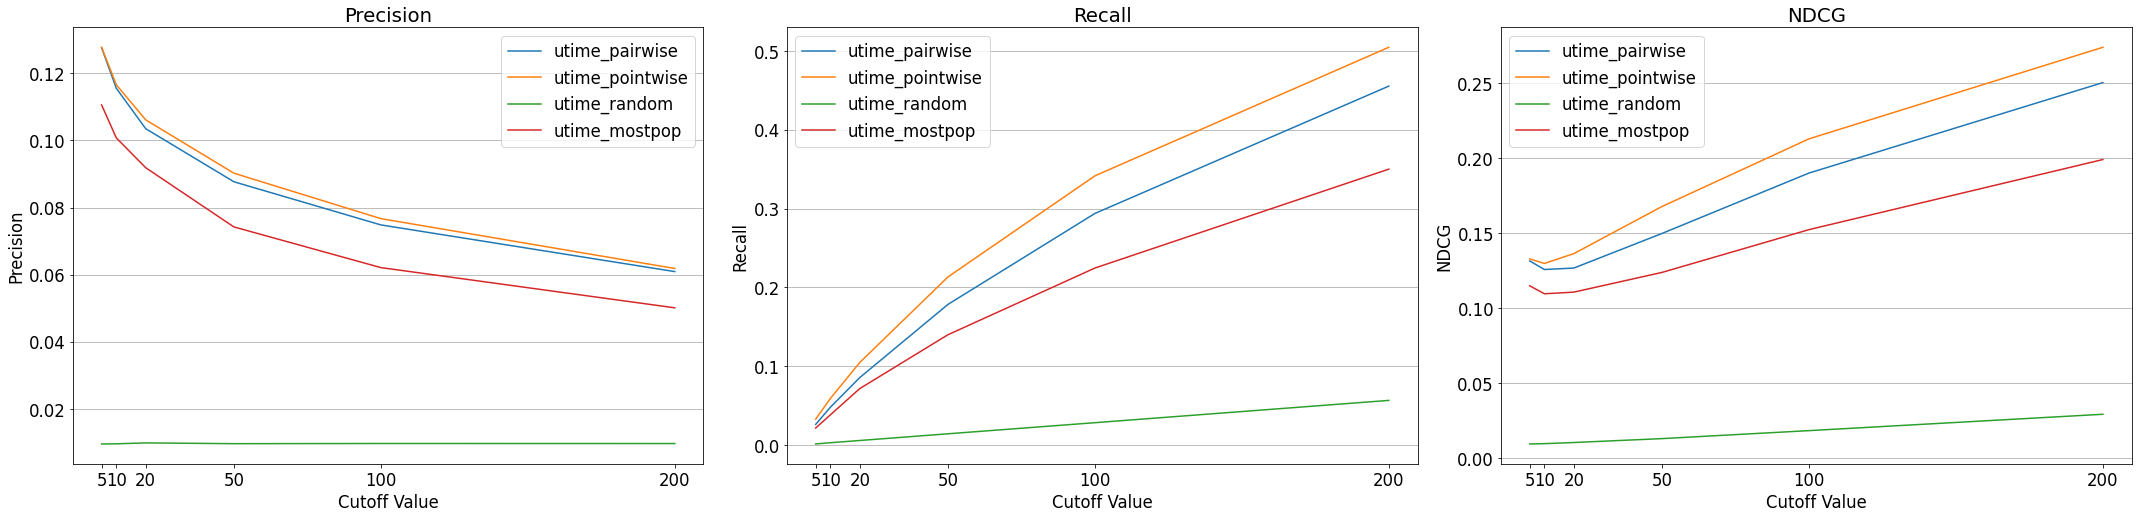

In [27]:
plot_effectiveness(metrics, cutoffs)

Then, we show the extent to which they are fair for the providers, based on the group-proportionality principles discussed above.  

In [28]:
def plot_disparities(metrics, cutoffs):
    plt.rcParams.update({'font.size': 16.5})
    plt.figure(figsize=(30, 7.5))

    plt.subplot(121)
    plt.title(r'Disparate Visibility')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Disparate Visibility')
    for model_type in model_types:
        plt.plot(cutoffs, [abs(np.mean(metrics[model_type]['visibility'][k,:]) - original_minority_rep) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(122)
    plt.title(r'Disparate Exposure')
    plt.xlabel('Cutoff Value')
    plt.ylabel('Disparate Exposure')
    for model_type in model_types:
        plt.plot(cutoffs, [abs(np.mean(metrics[model_type]['exposure'][k,:]) - original_minority_rep) for k in range(len(cutoffs))], label=model_type)
    plt.xticks(cutoffs)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()

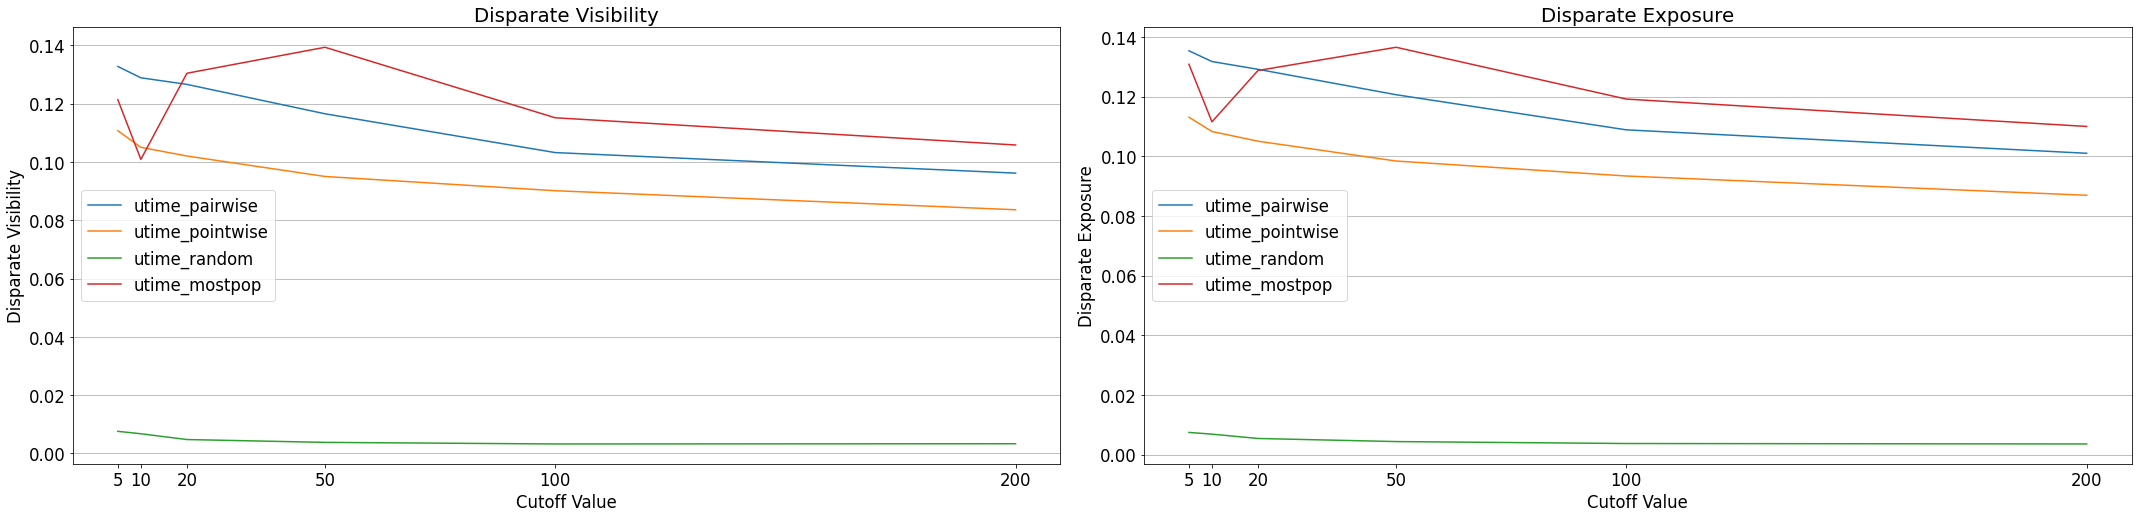

In [29]:
plot_disparities(metrics, cutoffs)

## Step 3: Improving fairness across provider-groups via pre-processing

This part will show how to improve fairness among provider groups by upsampling interactions involving the minority group of providers. This example is a didactic version of the work proposed by Boratto et al. (2020b). 

First, we split again train and test data and prepare the data needed to initialize a recommendation model. 

In [30]:
smode = 'utime_pfair'
train_ratio = 0.80        
min_train_samples = 8
min_test_samples = 2
min_time = None
max_time = None
step_time = 1000

In [31]:
if smode == 'uftime_pfair':
    traintest = fixed_timestamp(data, min_train_samples, min_test_samples, min_time, max_time, step_time, user_field, item_field, time_field, rating_field)
elif smode == 'utime_pfair':
    traintest = user_timestamp(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field, time_field)
elif smode == 'urandom_pfair':
    traintest = user_random(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field)

> Parsing user 6040 of 6040


In [32]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [33]:
len(train[train['minority'] > 0]) / len(train), len(train[train['minority'] == 0]) / len(train)

(0.078392830039388, 0.921607169960612)

In [34]:
train.sample(10)

,user_id,item_id,rating,timestamp,type,type_id,minority,majority,set,user_id_original,item_id_original
44594,4041,1781,4.0,2000-08-05 23:28:29,Drama,7,0.0,1.0,train,4042,1961
345333,4226,1919,4.0,2000-08-03 17:01:37,Fantasy,8,0.0,1.0,train,4227,2100
855945,1634,1744,5.0,2000-11-20 11:49:36,Sci-Fi,14,0.0,1.0,train,1635,1924
427968,5764,1653,2.0,2000-05-13 03:13:07,Action,0,0.0,1.0,train,5765,1831
419789,1585,2420,4.0,2000-11-20 17:02:34,Comedy,4,0.0,1.0,train,1586,2622
626872,172,2357,3.0,2001-03-22 19:33:44,Sci-Fi,14,0.0,1.0,train,173,2553
470782,343,1272,1.0,2000-12-09 05:35:00,Sci-Fi,14,0.0,1.0,train,344,1371
304446,3052,2202,5.0,2000-10-03 21:38:11,Comedy,4,0.0,1.0,train,3053,2395
851102,1086,2475,5.0,2001-05-22 18:14:46,Documentary,6,0.0,1.0,train,1087,2677
152754,3720,1777,3.0,2000-08-14 05:52:43,Drama,7,0.0,1.0,train,3721,1957


In [35]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [36]:
items_metadata = traintest.drop_duplicates(subset=['item_id'], keep='first')
category_per_item = items_metadata[type_field].values

Then, we identify the set of items belonging to the minority group and we run the upsampling strategy. 

In [37]:
items_w_min = np.unique(traintest[traintest['minority'] > 0]['item_id'].values)
items_w_maj = np.unique(traintest[traintest['minority'] == 0]['item_id'].values)

In [41]:
def run_with_upsampling(train, umode, utarget, model_type='pairwise', items_w_min=None, item_group=None, cutoffs=None, verbose=False):
    model_id = smode + '_' + umode + '_' + str(int(utarget*100)) + '_' + model_type
    
    print('\n*** Running experimental pipeline for model with id', model_id)
    
    if umode == 'real':
        train = real(train, 'minority', target=utarget)
    if umode == 'fake':
        train = fake(train, 'minority', items_w_min, target=utarget)
    if umode == 'fakebypop':
        train = fakeByPop(train, 'minority', items_w_min, target=utarget)
        
    train['rating'] = 1.0
    
    model_types = {'random': Random, 'mostpop': MostPop, 'pointwise': PointWise, 'pairwise': PairWise}
    model = model_types[model_type](users, items, train, test, category_per_item, item_field, user_field, rating_field)
    
    model.train(no_epochs=5)
    model.predict()
    
    predictions = model.get_predictions()
    save_obj(predictions, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + model_id + '_scores.pkl'))
    
    model.test(item_group=item_group, cutoffs=cutoffs)
    
    metrics = model.get_metrics()
    
    save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + model_id + '_metrics.pkl'))
    
    if verbose:
        model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

In [42]:
items_map = traintest.drop_duplicates(subset='item_id', keep='first')
item_group = {i: (0.0 if v > 0 else 1.0) for i, v in zip(items_map['item_id'].values, items_map['minority'].values)}

In [43]:
run_with_upsampling(train, 'fake', 0.16, 'pairwise', items_w_min, item_group, cutoffs, verbose=True)


*** Running experimental pipeline for model with id utime_pfair_fake_16_pairwise
original 803798 minority 0.078392830039388 and majority 0.921607169960612

upsampled 881888 minority 0.15999990928553284 and majority 0.8400000907144671
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Generating training instances of type pair
Created training instances randomly
Computing instances for interaction 800000 / 881888 of type pair
Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode pair
Train on 8730691 samples
8730691/8730691 [==============================] - 92s 11us/sample - loss: 0.2186 - acc_loss: 0.2186 - corr_loss: 0.3357
Validation accuracy: 0.8327569197972536 (Sample 88188 of 88189)
Train on 8730691 samples
Epoch 2/2
8730691/8730691 [=================

In [44]:
model_types = ['utime_pfair_fake_16_pairwise', 'utime_pairwise', 'utime_pointwise', 'utime_random', 'utime_mostpop']

In [45]:
metrics = load_metrics(model_types)

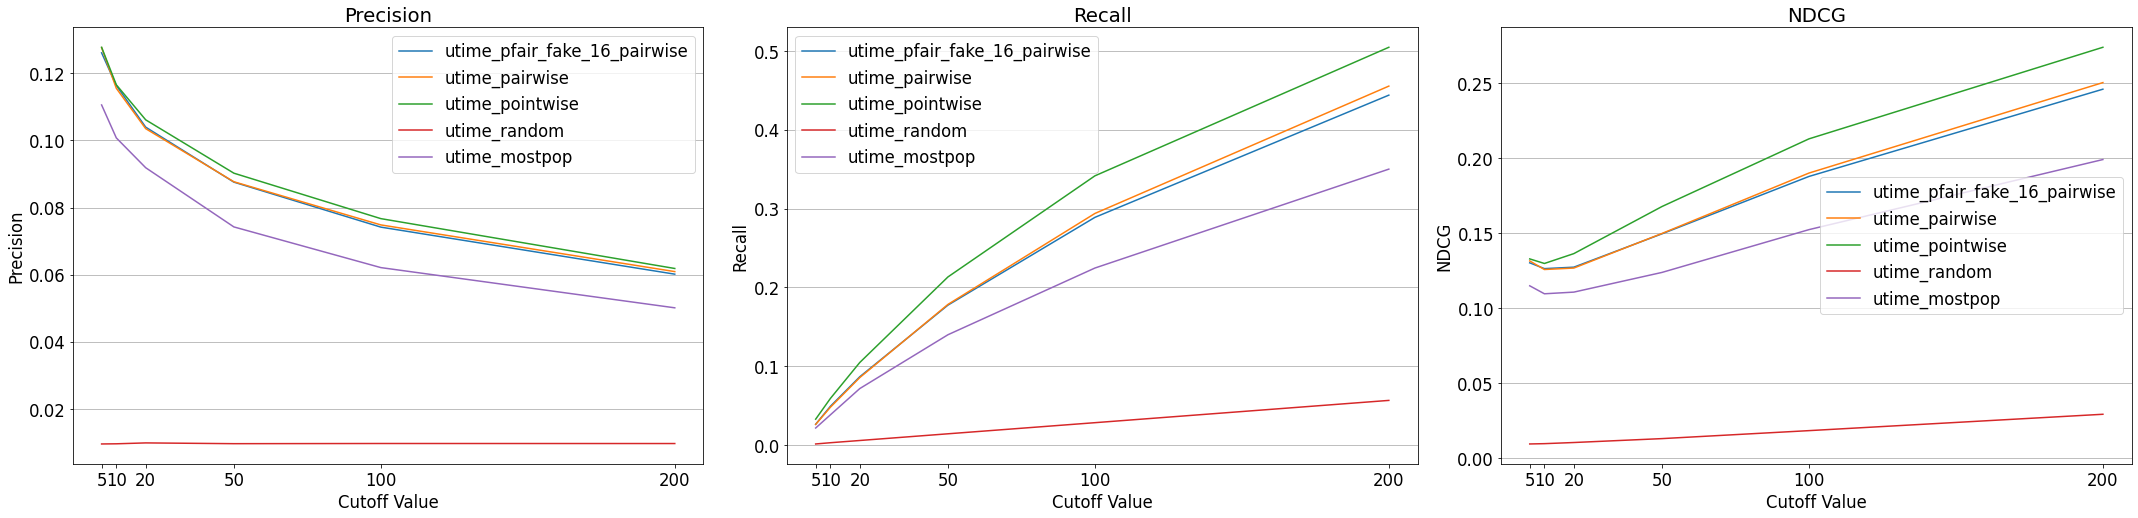

In [46]:
plot_effectiveness(metrics, cutoffs)

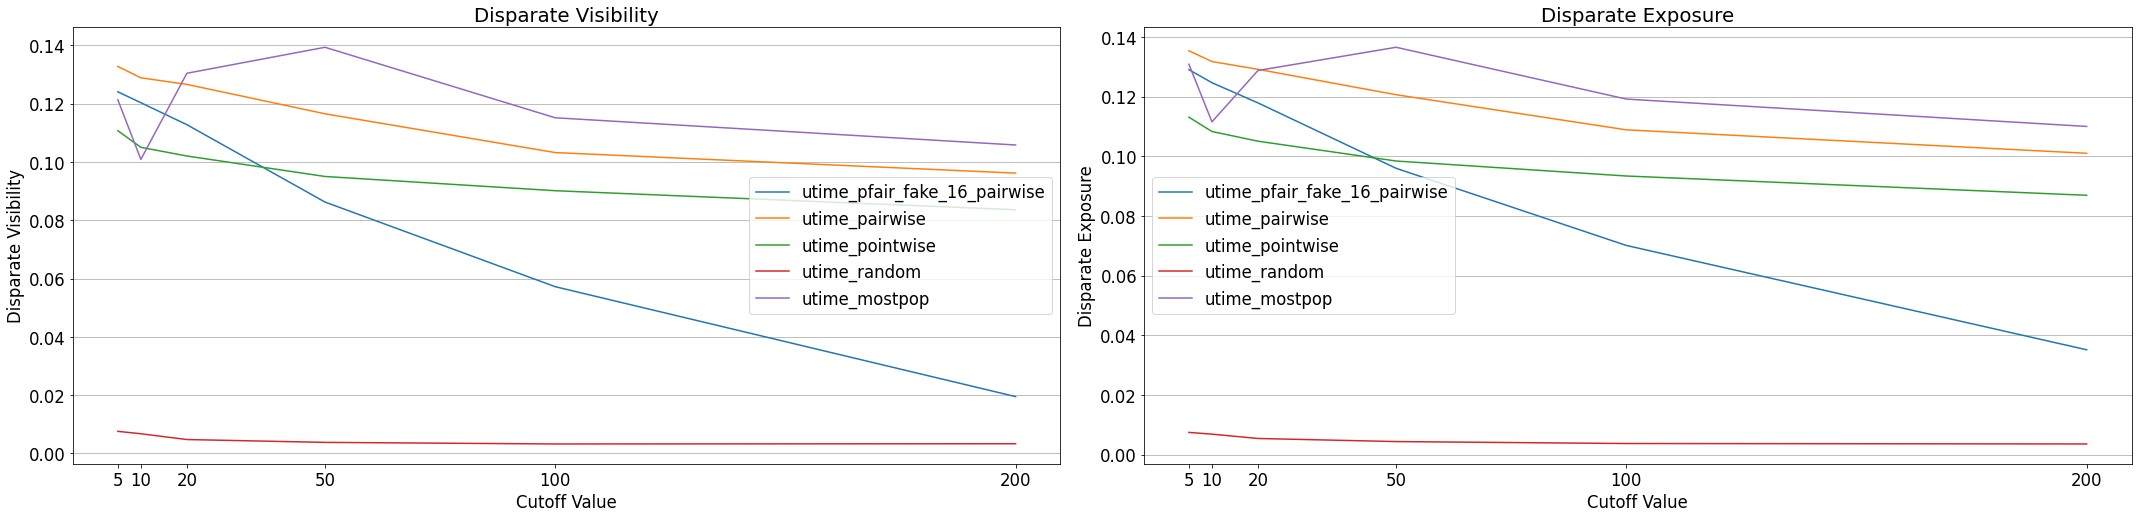

In [47]:
plot_disparities(metrics, cutoffs)

## Step 4: Analyzing the effect of the amount of upsampling

In the last step, we set up the amount of upsampling to *0.30*. However, it remains unanswered the question on to what extent the upsampling affects the disparities and which amount of upsampling should be selected for a given model. To answer to thi question, we run the procedure for a set of upsampling values and compare the tradeoff they achieve.  

In [48]:
upsampling_vars = [0.20, 0.25]

In [ ]:
for u in upsampling_vars:
    run_with_upsampling(train, 'fake', u, 'pairwise', items_w_min, item_group, cutoffs)


*** Running experimental pipeline for model with id utime_pfair_fake_20_pairwise
original 803798 minority 0.078392830039388 and majority 0.921607169960612
computing 100000 of 122184
upsampled 925982 minority 0.19999956802616034 and majority 0.8000004319738396
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Generating training instances of type pair
Created training instances randomly
Computing instances for interaction 900000 / 925982 of type pair
Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode pair
Train on 9167221 samples
9167221/9167221 [==============================] - 58s 6us/sample - loss: 0.2186 - acc_loss: 0.2185 - corr_loss: 0.3344
Validation accuracy: 0.8420069331202281 (Sample 92598 of 92599)
Train on 9167221 samples
Epoch 2/2
9167221/9

In [ ]:
model_types=['utime_pairwise','utime_pfair_fake_16_pairwise','utime_pfair_fake_20_pairwise','utime_pfair_fake_25_pairwise']

In [ ]:
metrics = load_metrics(model_types)

In [ ]:
plot_effectiveness(metrics, cutoffs)

In [ ]:
plot_disparities(metrics, cutoffs)

## Step 5: Investigate the impact on the coverage of the provider groups

In [ ]:
kindex = int(np.where(cutoffs == 50)[0])

In [ ]:
items_g1 = np.unique(traintest[traintest['minority'] > 0]['item_id'])
items_g2 = np.unique(traintest[traintest['minority'] == 0]['item_id'])

coverage_results = []
for model_type in model_types:
    coverage = len([1 for m in metrics[model_type]['item_coverage'][kindex] if m > 0]) / len(items)
    coverage_g1o = len([1 for m in metrics[model_type]['item_coverage'][kindex][items_g1] if m > 0]) / len(items)
    coverage_g2o = len([1 for m in metrics[model_type]['item_coverage'][kindex][items_g2] if m > 0]) / len(items)
    coverage_g1r = len([1 for m in metrics[model_type]['item_coverage'][kindex][items_g1] if m > 0]) / len(items_g1)
    coverage_g2r = len([1 for m in metrics[model_type]['item_coverage'][kindex][items_g2] if m > 0]) / len(items_g2)
    coverage_results.append([model_type, coverage, coverage_g1o, coverage_g2o, coverage_g1r, coverage_g2r])
    
pd.DataFrame(coverage_results, columns =['Model Type', 'Cov', 'G1 Over Cov', 'G2 Over Cov', 'G1 Rel Cov', 'G2 Rel Cov']) 